# Import

In [1]:
pip install tsplib95

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import tsplib95
from tqdm.auto import tqdm
import time
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# NSGA-II

## CPU

In [21]:
class NSGA_II:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

## GPU

In [61]:
@cuda.jit
def check_domination(pop_vals, dominated, dom_count):
    q, p = cuda.grid(2)

    pop_size = pop_vals.shape[0]
    if (p >= pop_size) or (q >= pop_size):
        return

    if (pop_vals[p][0] <= pop_vals[q][0] and pop_vals[p][1] <= pop_vals[q][1] and
        (pop_vals[p][0] < pop_vals[q][0] or pop_vals[p][1] < pop_vals[q][1])):
        dominated[p, q] = 1

    elif (pop_vals[q][0] <= pop_vals[p][0] and pop_vals[q][1] <= pop_vals[p][1] and
            (pop_vals[q][0] < pop_vals[p][0] or pop_vals[q][1] < pop_vals[p][1])):
        cuda.atomic.add(dom_count, p, 1)


@cuda.jit
def find_first_frontier(dom_count, frontier, rank):
    p = cuda.grid(1)
    if dom_count[p] == 0:
        frontier[p] = 1
        rank[p] = 1


@cuda.jit
def remove_current_frontier(dominated, dom_count, current_rank,
                            current_frontier, next_frontier, rank):
    q, p = cuda.grid(2)

    pop_size = dominated.shape[0]
    if (p >= pop_size) or (q >= pop_size) or current_frontier[p] == 0:
        return
    
    if dominated[p, q] == 1:
        if cuda.atomic.add(dom_count, q, -1) == 1:
            rank[q] = current_rank
            next_frontier[q] = 1

In [27]:
class NSGA_II_GPU:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)

        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='int32')
        next_frontier = np.zeros(pop_size, dtype='int32')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='int32')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]

        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

# MOTSP

## Operatory krzyżowania

In [4]:
def PMX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]

    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]

    map = {}
    for chrom in swath1:
        if chrom in swath2:
            continue
        else:
            paired = chrom
            while(paired in swath1):
                paired = swath2[getIdx(paired, swath1)]
            map[paired] = chrom
            map[chrom] = paired
    oldInd1, oldInd2 = ind1, ind2

    for idx in range(len(ind1)):
        chrom = ind1[idx]
        if (chrom in swath2) and (chrom in map):
            ind1[idx] = map[chrom]
    ind1[i:j] = swath2

    for idx in range(len(ind1)):
        chrom = ind2[idx]
        if (chrom in swath1) and (chrom in map):
            ind2[idx] = map[chrom]
    ind2[i:j] = swath1

    return ind1, ind2


def OX(ind1, ind2):
    a = np.random.choice(len(ind1), 2, False)
    i, j = a.min(), a.max()+1
    swath1 = ind1[i:j]
    swath2 = ind2[i:j]
    
    rest2 = np.array([chrom for chrom in ind1 if chrom not in swath2])
    rest1 = np.array([chrom for chrom in ind2 if chrom not in swath1])
    
    ind1 = np.concatenate((rest2[0:i], swath2, rest2[i:]))
    ind2 = np.concatenate((rest1[0:i], swath1, rest1[i:]))
    
    return ind1, ind2


def CX(ind1, ind2):

    def getIdx(val, arr):
        result = np.where(arr == val)
        return result[0][0]
        
    def color_cycle(idx):
        while cycles[idx] == 0 :
            cycles[idx] = color
            idx = getIdx(ind2[idx], ind1)

    cycles = np.zeros(len(ind1))
    color = 1
    for idx in range(len(ind1)):
        if cycles[idx] == 0 :
            color_cycle(idx)
            color += 1

    mask = (cycles%2).astype(bool)


    child1, child2 = np.zeros(len(ind1)), np.zeros(len(ind1))
    child1[mask], child2[mask] = ind1[mask], ind2[mask]
    neg = np.logical_not
    child1[neg(mask)], child2[neg(mask)] = ind2[neg(mask)], ind1[neg(mask)]
    
    return child1, child2

## Operatory mutacji

In [5]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def element_transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i], q[j] = q[j], q[i]
    return q

def insert_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q = np.concatenate((q[0:i], q[j:j+1], q[i:j], q[j+1:]))
    return q

## Funkcja celu

In [6]:
def generate_distance_matrix(problem_size, *problems):
    M = np.empty((len(problems), problem_size, problem_size), dtype='int32')
    for prob in range(len(problems)):
        coords = problems[prob].as_dict()['node_coords']
        coords = np.array(list(coords.values()))
        for i in range(problem_size):
            for j in range(problem_size):
                M[prob, i, j] = np.sqrt(((coords[i] - coords[j])**2).sum())
    return M

def tsp_objective_function(perm, objectives_number, distance_matrix):
    result = np.zeros(objectives_number)
    for i in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += distance_matrix[obj][perm[i-1]][perm[i]]
    return result

def evaluate_population_cpu(population, distance_matrix, objectives_number):
    pop_size = population.shape[0]
    vals = np.empty((pop_size, objectives_number))
    for i in range(pop_size):
        vals[i] = tsp_objective_function(population[i], objectives_number, distance_matrix)
    return vals

In [7]:
@cuda.jit
def evaluate_population(population, distance, res):

    k, obj, ind = cuda.grid(3)

    pop_size, chrom_len = population.shape
    if (ind >= pop_size) or (k >= chrom_len):
        return

    idx = population[ind][k]
    next_idx = population[ind][(k+1)%chrom_len]
    value = distance[obj][idx][next_idx]
    d = 16
    while d>0:
        value += cuda.shfl_down_sync(0xffffffff, value, d)
        d >>= 1
    if (k % 32) == 0:
        cuda.atomic.add(res, (ind, obj), value)
    return 

## Przykładowy problem MOTSP

In [8]:
def generate_population(pop_size, chrom_len):
    pop = np.empty((pop_size, chrom_len), dtype='int32')
    for i in range(pop_size):
        ind = np.random.permutation(chrom_len)
        pop[i] = ind
    return pop

In [9]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)

In [10]:
chrom_len = 100
pop_size = 256
obj_num = 2
n_iters = 50

init_pop = generate_population(pop_size, chrom_len)
init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)
    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

NameError: ignored

# Testy

## euclidAB100

In [20]:
problemA = tsplib95.load("euclidA100.tsp")
problemB = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

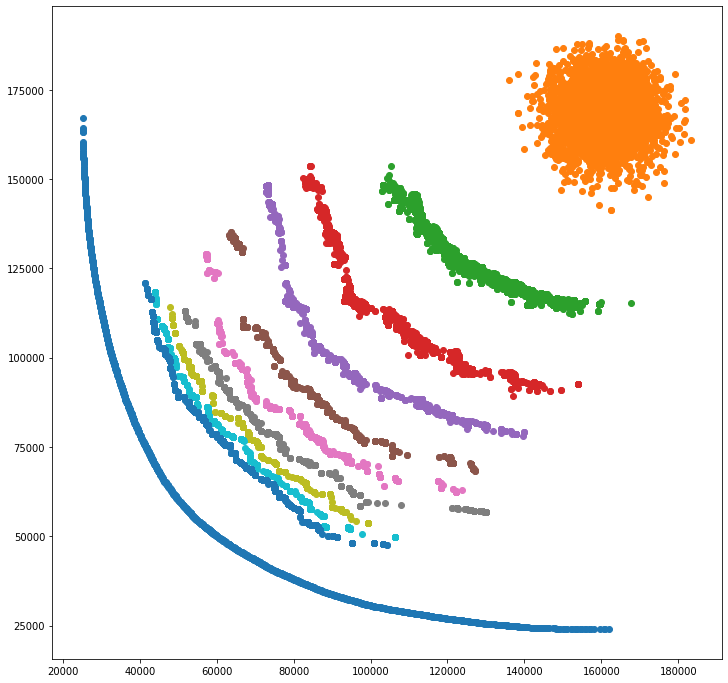

In [94]:
chrom_len = 100
pop_size = 4096
obj_num = 2
n_iters = 500

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')


evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children = children.astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

## kroAB100

In [55]:
kroA100 = tsplib95.load('/content/gdrive/My Drive/TSPLIB/kroA100.tsp')
kroB100 = tsplib95.load('/content/gdrive/My Drive/TSPLIB/kroB100.tsp')

In [56]:
distance_matrix = generate_distance_matrix(100, kroA100, kroB100)

In [57]:
d_distance = cuda.to_device(distance_matrix)

In [51]:
solutionsAB = np.loadtxt('points.3.1', dtype='int32', usecols=np.arange(6, 106))
solutionsAB.shape

(2699, 100)

In [58]:
sol_vals = np.zeros((100, 2))

griddim = (1, 1, 2699)
blockdim = (128, 2, 1)

evaluate_population[griddim, blockdim](solutionsAB, d_distance, sol_vals)

In [59]:
sol_vals[:5]

array([[47457., 53280.],
       [49474., 51289.],
       [48996., 51772.],
       [65941., 38733.],
       [59132., 43080.]])

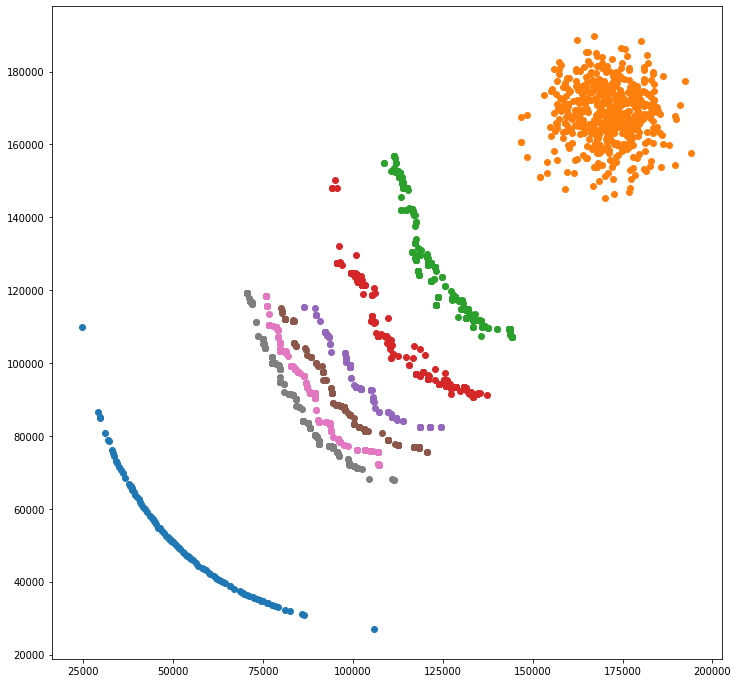

In [65]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 300

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')


evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(sol_vals[:, 0], sol_vals[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    children = children.astype('int32')

    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])

# CUDA

## CPU - czas działania

In [17]:
class NSGA_II_prints:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, objective_values):

        def dominates(vals1, vals2):
            return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

        size = objective_values.shape[0]
        pareto_frontier = np.empty(size, dtype=int)
        current_frontier_number = 1
        current_frontier_members = []
        # number of solutions dominating p
        dominating_count = np.zeros(size, dtype=int)
        # set of solutions dominated by p
        dominated = [None] * size 

        for p in range(size):
            dominated[p] = []
            for q in range(size):
                if dominates(objective_values[p], objective_values[q]):
                    dominated[p].append(q)
                elif dominates(objective_values[q], objective_values[p]):
                    dominating_count[p] += 1
            if dominating_count[p] == 0:
                pareto_frontier[p] = current_frontier_number
                current_frontier_members.append(p)

        while current_frontier_members != []:
            current_frontier_number += 1
            new_frontier_members = []
            for p in current_frontier_members:
                for q in dominated[p]:
                    dominating_count[q] -= 1
                    if dominating_count[q] == 0:
                        pareto_frontier[q] = current_frontier_number
                        new_frontier_members.append(q)
            current_frontier_members = new_frontier_members
        
        return pareto_frontier


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]


        time1 = time.time()

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]

        print("     Selection:                      ", time.time() - time1)

        time1 = time.time()
        # creating children population
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]
        print("     Recombination:                  ", time.time() - time1)

        time1 = time.time()
        # mutating children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])
        print("     Mutation:                       ", time.time() - time1)

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        time2 = time.time()
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        print("         Non dominated sort:         ", time.time() - time2)


        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        time2 = time.time()
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]
        print("         Distance assignment:        ", time.time() - time2)

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

In [67]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)

In [18]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 10

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          2.532703399658203
         Distance assignment:         0.0018694400787353516

Iteration number:                     0

     Selection:                       0.022581100463867188
     Recombination:                   0.3178520202636719
     Mutation:                        0.005914926528930664
     Population evaluation:           0.1398928165435791
     Population replacement:
         Non dominated sort:          10.527567386627197
         Distance assignment:         0.001996755599975586
     Population replacement - sum:    10.532180070877075

Iteration - sum:                      11.019808053970337

Iteration number:                     1

     Selection:                       0.020178556442260742
     Recombination:                   0.2497262954711914
     Mutation:                        0.0033752918243408203
     Population evaluation:           0.13043665885925293
     Population replacement:
         Non dominated sort:

## Ewaluacja funkcji celu

In [ ]:
def generate_population(pop_size, chrom_len):
    pop = np.empty((pop_size, chrom_len), dtype='int32')
    for i in range(pop_size):
        ind = np.random.permutation(chrom_len)
        pop[i] = ind
    return pop

def generate_distance_matrix(problem_size, *problems):
    M = np.empty((len(problems), problem_size, problem_size), dtype='int32')
    for prob in range(len(problems)):
        coords = problems[prob].as_dict()['node_coords']
        coords = np.array(list(coords.values()))
        for i in range(problem_size):
            for j in range(problem_size):
                M[prob, i, j] = np.sqrt(((coords[i] - coords[j])**2).sum())
    return M

def tsp_objective_function(perm, objectives_number, distance_matrix):
    result = np.zeros(objectives_number)
    for i in range(perm.shape[0]):
        for obj in range(objectives_number):
            result[obj] += distance_matrix[obj][perm[i-1]][perm[i]]
    return result

def evaluate_population_cpu(population, distance_matrix, objectives_number):
    pop_size = population.shape[0]
    vals = np.empty((pop_size, objectives_number))
    for i in range(pop_size):
        vals[i] = tsp_objective_function(population[i], objectives_number, distance_matrix)
    return vals

In [ ]:
@cuda.jit
def evaluate_population(population, distance, res):

    k, obj, ind = cuda.grid(3)

    pop_size, chrom_len = population.shape
    if (ind >= pop_size) or (k >= chrom_len):
        return

    idx = population[ind][k]
    next_idx = population[ind][(k+1)%chrom_len]
    value = distance[obj][idx][next_idx]
    d = 16
    while d>0:
        value += cuda.shfl_down_sync(0xffffffff, value, d)
        d >>= 1
    if (k % 32) == 0:
        cuda.atomic.add(res, (ind, obj), value)
    return 

In [ ]:
problemA = tsplib95.load("euclidA100.tsp")
problemB = tsplib95.load("euclidB100.tsp")

In [ ]:
chrom_len = 100
pop_size = 2048
obj_num = 2

init_pop = generate_population(pop_size, chrom_len)

In [ ]:
distance = generate_distance_matrix(100, problemA, problemB)

In [ ]:
d_distance = cuda.to_device(distance)

In [ ]:
res = np.zeros((pop_size, obj_num), dtype='int32')
blocks_per_grid = (1, 1, pop_size)
blockdim = (128, 2, 1)

%timeit evaluate_population[blocks_per_grid, blockdim](init_pop, d_distance, res)
%timeit evaluate_population_cpu(init_pop, distance, 2)

1000 loops, best of 3: 1.54 ms per loop
1 loop, best of 3: 531 ms per loop


In [ ]:
n_iters = 10

for t in range(n_iters):
    population = generate_population(pop_size, chrom_len)

    vals_gpu = np.zeros((pop_size, obj_num), dtype='int32')

    blocks_per_grid = (1, 1, pop_size)
    blockdim = (128, 2, 1)
    evaluate_population[blocks_per_grid, blockdim](population, d_distance, vals_gpu)

    vals_cpu = evaluate_population_cpu(population, distance, obj_num)

    assert np.all(vals_gpu == vals_cpu)

## Sortowanie

In [ ]:
def non_dominated_sort_cpu(objective_values):

    def dominates(vals1, vals2):
        return np.all(vals1 <= vals2) and np.any(vals1 < vals2)

    size = objective_values.shape[0]
    pareto_frontier = np.empty(size, dtype=int)
    current_frontier_number = 1
    current_frontier_members = []
    # number of solutions dominating p
    dominating_count = np.zeros(size, dtype=int)
    # set of solutions dominated by p
    dominated = [None] * size 

    for p in range(size):
        dominated[p] = []
        for q in range(size):
            if dominates(objective_values[p], objective_values[q]):
                dominated[p].append(q)
            elif dominates(objective_values[q], objective_values[p]):
                dominating_count[p] += 1
        if dominating_count[p] == 0:
            pareto_frontier[p] = current_frontier_number
            current_frontier_members.append(p)

    while current_frontier_members != []:
        current_frontier_number += 1
        new_frontier_members = []
        for p in current_frontier_members:
            for q in dominated[p]:
                dominating_count[q] -= 1
                if dominating_count[q] == 0:
                    pareto_frontier[q] = current_frontier_number
                    new_frontier_members.append(q)
        current_frontier_members = new_frontier_members
    
    return pareto_frontier

In [14]:
@cuda.jit
def check_domination(pop_vals, dominated, dom_count):
    q, p = cuda.grid(2)

    pop_size = pop_vals.shape[0]
    if (p >= pop_size) or (q >= pop_size):
        return

    if (pop_vals[p][0] <= pop_vals[q][0] and pop_vals[p][1] <= pop_vals[q][1] and
        (pop_vals[p][0] < pop_vals[q][0] or pop_vals[p][1] < pop_vals[q][1])):
        # maska bitowa = atomic add
        dominated[p, q] = 1


    elif (pop_vals[q][0] <= pop_vals[p][0] and pop_vals[q][1] <= pop_vals[p][1] and
            (pop_vals[q][0] < pop_vals[p][0] or pop_vals[q][1] < pop_vals[p][1])):
        cuda.atomic.add(dom_count, p, 1)


@cuda.jit
def find_first_frontier(dom_count, frontier, rank):
    p = cuda.grid(1)
    if dom_count[p] == 0:
        frontier[p] = 1
        rank[p] = 1


@cuda.jit
def remove_current_frontier(dominated, dom_count, current_rank,
                            current_frontier, next_frontier, rank):
    q, p = cuda.grid(2)

    pop_size = dominated.shape[0]
    if (p >= pop_size) or (q >= pop_size) or current_frontier[p] == 0:
        return
    
    if dominated[p, q] == 1:
        if cuda.atomic.add(dom_count, q, -1) == 1:
            rank[q] = current_rank
            next_frontier[q] = 1

In [ ]:
def non_dominated_sort(pop_vals):

    def is_not_empty(frontier):
        return np.any(frontier == 1)


    pop_size = pop_vals.shape[0]

    current_frontier = np.zeros(pop_size, dtype='int32')
    next_frontier = np.zeros(pop_size, dtype='int32')
    current_rank = 1

    dom = np.zeros((pop_size, pop_size), dtype='int32')
    dom_count = np.zeros(pop_size, dtype='int32')
    rank = np.zeros(pop_size, dtype='int32')

    d_dom = cuda.to_device(dom)
    d_dom_count = cuda.to_device(dom_count)
    d_rank = cuda.to_device(rank)

    griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
    blockdim = (32, 32)

    check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
    find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

    while(is_not_empty(current_frontier)):
        next_frontier = np.zeros(pop_size)
        current_rank += 1
        remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                       current_frontier, next_frontier, d_rank)
        current_frontier = next_frontier

    rank = d_rank.copy_to_host()
    return rank

In [ ]:
chrom_len = 100
pop_size = 2048
obj_num = 2

population = generate_population(pop_size, chrom_len)

vals = np.zeros((pop_size, obj_num), dtype='int32')

blocks_per_grid = (1, 1, pop_size)
blockdim = (128, 2, 1)
evaluate_population[blocks_per_grid, blockdim](population, d_distance, vals)

In [ ]:
%timeit non_dominated_sort(vals)
%timeit non_dominated_sort_cpu(vals)

10 loops, best of 3: 68 ms per loop
1 loop, best of 3: 9.46 s per loop


In [ ]:
assert np.all(non_dominated_sort(vals) == non_dominated_sort_cpu(vals))

(2048, 2)


## GPU - czas działania

In [19]:
class NSGA_II_GPU_prints:
    def __init__(self, chromosome_length, population_size, objectives_number,
                 initial_population, initial_objective_values):
        self.chromosome_length = chromosome_length
        self.population_size = population_size
        self.objectives_number = objectives_number
        if type(initial_population) is not np.ndarray:
            raise ValueError("initial population must be a numpy array")
        if initial_population.shape != (self.population_size, self.chromosome_length):
            raise ValueError("initial population must be of shape (population_size, chromosome_length)")
        self.current_population = initial_population
        if type(initial_objective_values) is not np.ndarray:
            raise ValueError("initial objective values must be a numpy array")
        if initial_objective_values.shape != (self.population_size, self.objectives_number):
            raise ValueError("initial population values must be of shape (population_size, objectives_number)")
        self.current_objective_values = initial_objective_values
        self.current_pareto_frontier = np.empty(self.population_size)
        self.current_crowding_distances = np.empty(self.population_size)
        self.replace_population(None, None)


    def get_population(self):
        return self.current_population


    def get_values(self):
        return self.current_objective_values


    def non_dominated_sort(self, pop_vals):

        def is_not_empty(frontier):
            return np.any(frontier == 1)

        pop_size = pop_vals.shape[0]

        current_frontier = np.zeros(pop_size, dtype='int32')
        next_frontier = np.zeros(pop_size, dtype='int32')
        current_rank = 1

        dom = np.zeros((pop_size, pop_size), dtype='int32')
        dom_count = np.zeros(pop_size, dtype='int32')
        rank = np.zeros(pop_size, dtype='int32')

        d_dom = cuda.to_device(dom)
        d_dom_count = cuda.to_device(dom_count)
        d_rank = cuda.to_device(rank)

        griddim  = (max(pop_size//32, 1), max(pop_size//32, 1))
        blockdim = (32, 32)

        check_domination[griddim, blockdim](pop_vals, d_dom, d_dom_count)
        find_first_frontier[max(pop_size//1024, 1), 1024](d_dom_count, current_frontier, d_rank)

        while(is_not_empty(current_frontier)):
            next_frontier = np.zeros(pop_size)
            current_rank += 1
            remove_current_frontier[griddim, blockdim](d_dom, d_dom_count, current_rank,
                                                        current_frontier, next_frontier, d_rank)
            current_frontier = next_frontier

        rank = d_rank.copy_to_host()
        return rank


    def assign_crowding_distance(self, objective_values):
        size = objective_values.shape[0]
        distance = np.zeros(size)
        for current_objective in range(self.objectives_number):
            current_objective_values = objective_values[:, current_objective]
            sorted_indices = np.argsort(current_objective_values)
            current_objective_values_diff = current_objective_values[sorted_indices[-1]] - current_objective_values[sorted_indices[0]]
            if current_objective_values_diff == 0:
                continue
            distance[sorted_indices[0]], distance[sorted_indices[-1]] = np.inf, np.inf
            for i in range(1, size-1):
                distance[sorted_indices[i]] += ((current_objective_values[sorted_indices[i+1]] - current_objective_values[sorted_indices[i-1]]) /
                                                current_objective_values_diff)
        return distance


    def generate_children(self, crossover_operator, mutation_operator,
                          crossover_probability = 0.95, mutation_probability = 0.25,
                          number_of_offspring = None):

        def compare(p, q):
            if self.current_pareto_frontier[p] == self.current_pareto_frontier[q]:
                return self.current_crowding_distances[p] > self.current_crowding_distances[q]
            return self.current_pareto_frontier[p] > self.current_pareto_frontier[q]

        if number_of_offspring is None:
            number_of_offspring = self.population_size

        # selecting parent indices by the binary tournament method
        time1 = time.time()
        parent_indices = np.empty(number_of_offspring, dtype=np.int64)
        for i in range(number_of_offspring):
            candidates = np.random.choice(self.population_size, 2, False)
            if compare(candidates[0], candidates[1]):
                parent_indices[i] = candidates[0]
            else:
                parent_indices[i] = candidates[1]
        print("     Selection:                      ", time.time() - time1)

        # creating children population
        time1 = time.time()
        children_population = np.empty((number_of_offspring, self.chromosome_length), dtype='int32')
        for i in range(number_of_offspring//2):
            if np.random.random() < crossover_probability:
                children_population[2*i], children_population[2*i+1] = crossover_operator(self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy())
            else:
                children_population[2*i], children_population[2*i+1] = self.current_population[parent_indices[2*i]].copy(), self.current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1] = self.current_population[parent_indices[-1]]
        print("     Recombination:                  ", time.time() - time1)

        # mutating children population
        time1 = time.time()
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i] = mutation_operator(children_population[i])
        print("     Mutation:                       ", time.time() - time1)

        return children_population


    def replace_population(self, children_population, children_objective_values):

        if(children_population is None and children_objective_values is None):
            combined_population = self.current_population
            combined_objective_values = self.current_objective_values
        else:
            combined_population = np.vstack((self.current_population, children_population))
            combined_objective_values = np.vstack((self.current_objective_values, children_objective_values))

        time2 = time.time()
        combined_pareto_frontier = self.non_dominated_sort(combined_objective_values)
        print("         Non dominated sort:         ", time.time() - time2)

        positions = np.argsort(combined_pareto_frontier)

        combined_population = combined_population[positions]
        combined_objective_values = combined_objective_values[positions]
        combined_pareto_frontier = combined_pareto_frontier[positions]

        # assign crowding distance and select subset of last frontier
        found_population_size = 0
        current_frontier_number = 1
        current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                    np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
        current_frontier_size = current_frontier_rb - current_frontier_lb
        time2 = time.time()
        while found_population_size + current_frontier_size < self.population_size:
            found_population_size += current_frontier_size
            current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
            self.current_crowding_distances[current_frontier_lb : current_frontier_rb] = current_frontier_distances
            current_frontier_number += 1
            current_frontier_lb, current_frontier_rb = (np.searchsorted(combined_pareto_frontier, current_frontier_number),
                                                        np.searchsorted(combined_pareto_frontier, current_frontier_number, side='right'))
            current_frontier_size = current_frontier_rb - current_frontier_lb

        current_frontier_distances = self.assign_crowding_distance(combined_objective_values[current_frontier_lb : current_frontier_rb])
        last_frontier_taken_indices = np.argsort(current_frontier_distances)[::-1][:self.population_size - found_population_size]
        print("         Distance assignment:        ", time.time() - time2)

        combined_population[current_frontier_lb : self.population_size] = combined_population[last_frontier_taken_indices]
        combined_objective_values[current_frontier_lb : self.population_size] = combined_objective_values[last_frontier_taken_indices]
        self.current_crowding_distances[current_frontier_lb : self.population_size] = current_frontier_distances[last_frontier_taken_indices]

        self.current_population = combined_population[:self.population_size]
        self.current_objective_values = combined_objective_values[:self.population_size]
        self.current_pareto_frontier = combined_pareto_frontier[:self.population_size]

        return True

In [12]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

In [25]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 10

griddim = (1, 1, pop_size)
blockdim = (128, 2, 1)

print("Initialization: ")
init_pop = generate_population(pop_size, chrom_len)
init_vals = np.zeros((pop_size, obj_num), dtype='int32')
evaluate_population[griddim, blockdim](init_pop, d_distance, init_vals)

nsga_ii = NSGA_II_GPU_prints(chrom_len, pop_size, obj_num, init_pop, init_vals)

for t in range(n_iters):
    print()
    print("Iteration number:                    ", t)
    print()
    t0 = time.time()

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)
    t1 = time.time()
    children_vals = np.zeros((children.shape[0], obj_num), dtype='int32')
    evaluate_population[griddim, blockdim](children, d_distance, children_vals)
    print("     Population evaluation:          ", time.time() - t1)

    print("     Population replacement:")
    t1 = time.time()
    nsga_ii.replace_population(children, children_vals)
    print("     Population replacement - sum:   ", time.time() - t1)

    print()
    print("Iteration - sum:                     ", time.time() - t0)


Initialization: 
         Non dominated sort:          0.04922318458557129
         Distance assignment:         0.0018167495727539062

Iteration number:                     0

     Selection:                       0.019443750381469727
     Recombination:                   0.26180005073547363
     Mutation:                        0.0036439895629882812
     Population evaluation:           0.002460479736328125
     Population replacement:
         Non dominated sort:          0.05821657180786133
         Distance assignment:         0.001598358154296875
     Population replacement - sum:    0.06086087226867676

Iteration - sum:                      0.34987592697143555

Iteration number:                     1

     Selection:                       0.011914253234863281
     Recombination:                   0.256131649017334
     Mutation:                        0.0036163330078125
     Population evaluation:           0.0019578933715820312
     Population replacement:
         Non dominate

Dla populacji wielkości 512 udało się zredukować czas sortowania z ~ 9.5 sekundy do ~ 0.04 sekundy,  
tym samym zmniejszając czas trwania iteracji z ~ 9.8 sekundy do ~ 0.34 sekundy

## Algorytm w praktyce - CPU

In [26]:
euclidA100 = tsplib95.load("euclidA100.tsp")
euclidB100 = tsplib95.load("euclidB100.tsp")

solutionsAB = np.loadtxt('best.euclidAB100.tsp', dtype=int)

distance_matrix = generate_distance_matrix(100, euclidA100, euclidB100)
d_distance = cuda.to_device(distance_matrix)

KeyboardInterrupt: ignored

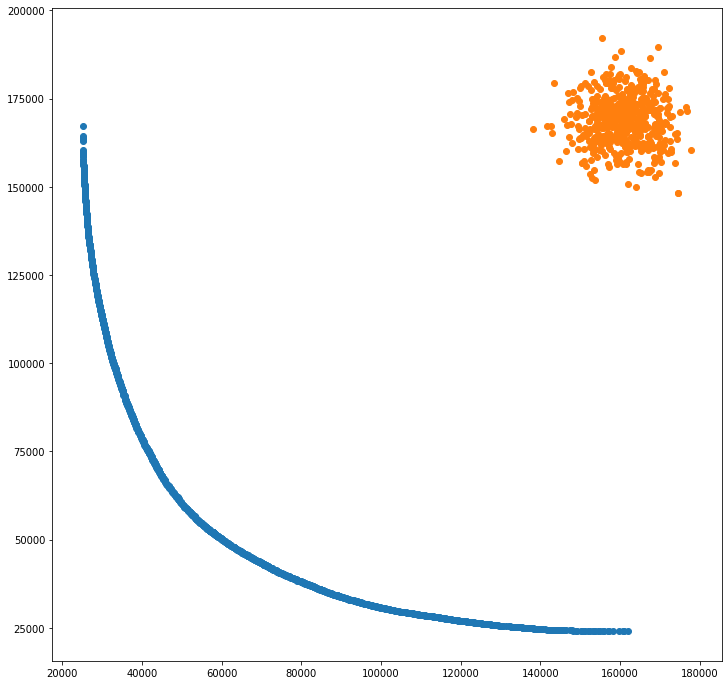

In [29]:
chrom_len = 100
pop_size = 512
obj_num = 2
n_iters = 300

init_pop = np.empty((pop_size, chrom_len), dtype='int32')

for i in range(pop_size):
    ind = np.random.permutation(chrom_len)
    init_pop[i] = ind
    
init_vals = np.zeros((pop_size, obj_num), dtype='int32')


init_vals = evaluate_population_cpu(init_pop, distance_matrix, obj_num)

nsga_ii = NSGA_II(chrom_len, pop_size, obj_num, init_pop, init_vals)

plt.figure(figsize=(12,12))
plt.scatter(solutionsAB[:, 0], solutionsAB[:, 1])

for t in tqdm(range(n_iters)):

    if(np.mod(t, 50) == 0):
        current_vals = nsga_ii.get_values()
        plt.scatter(current_vals[:, 0], current_vals[:, 1])

    children = nsga_ii.generate_children(PMX, reverse_sequence_mutation)

    children_vals = evaluate_population_cpu(children, distance_matrix, obj_num)

    nsga_ii.replace_population(children, children_vals)

current_vals = nsga_ii.get_values()
plt.scatter(current_vals[:, 0], current_vals[:, 1])